In [2]:
%matplotlib inline

import bloscpack as bp
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import sys 

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from metadata import *
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from data_manager import DataManager

def get_npz_data(filename):
    filename = filename+'.npz'
    filecontents = np.load(filename)
    data = filecontents['data']
    del filecontents
    return data


def blosc_to_npz(filename):
    if '.' in filename:
        file = filename
    else:
        file = filename+".bp";

    a = bp.unpack_ndarray_file(file)
    b = np.asarray(a)

    np.savez(filename+'.npz', data=b) # Save matrix as .npz file

    print('Size of bloscpack data:')
    print(np.shape(b))
    print('')

def read_loc_into_array(filename):
    file = open(filename+'.bp', 'r')
    points = []

    for line in file:
        x, y = line.split(' ')
        x = int( x )
        y = int( y.replace('\n','') )
        points.append( [x,y] )
    return points

def change_plot_sizes( width=8, length=6):
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]

    # Prints: [8.0, 6.0]
    print "Current size:", fig_size

    # Set figure width to 12 and height to 9
    fig_size[0] = width
    fig_size[1] = length
    plt.rcParams["figure.figsize"] = fig_size

# Built in functions

In [7]:
# Load atlas volumes
atlas_spec = dict(name='atlasV7',
                   vol_type='score',
                   resolution='10.0um'
                   )
# volume = atlas_structures_wrt_canonicalAtlasSpace_atlasResol[structure][0]
# offset = atlas_structures_wrt_canonicalAtlasSpace_atlasResol[structure][1]
atlas_structures_wrt_canonicalAtlasSpace_atlasResol = \
DataManager.load_original_volume_all_known_structures_v3(atlas_spec, in_bbox_wrt='canonicalAtlasSpace',
                                                         out_bbox_wrt='canonicalAtlasSpace')

Prior structure/index map not found. Generating a new one.


In [ ]:
### Compute score maps. ###

bg_img_version = 'gray'

# Load mxnet model
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name,
                                   num_gpus=1, batch_size=batch_size)
out_resolution_um = 10 # um

detector_setting = detector_settings.loc[detector_id]
clfs = DataManager.load_classifiers(classifier_id=detector_setting['feature_classifier_id'])
win_id = detector_setting['windowing_id']

viz_all_landmarks, scoremap_all_landmarks = \
            draw_scoremap(
                    clfs={name_u: clfs[name_u]},
                    bbox=bbox,
                    scheme='none',
                    win_id=win_id, prep_id=2,
                    stack=stack,
                    return_what='both',
                    sec=sec,
                    model=model, model_name=model_name,
                    mean_img=mean_img,
                    batch_size=batch_size,
                    output_patch_size=224,
                    is_nissl=False,
                    out_resolution_um=out_resolution_um,
                    bg_img_version=bg_img_version,
                    image_shape=metadata_cache['image_shape'][stack],
                    return_wholeimage=True)
sm = scoremap_all_landmarks[name_u]
viz = viz_all_landmarks[name_u]

In [14]:
# Load downsampled scoremap

stack="MD585"
section=305
name_u="7n"
out_resolution_um=10
detector_id=19

scoremap = DataManager.load_downscaled_scoremap(stack=stack, section=section, structure=name_u,
                                                prep_id='alignedBrainstemCrop',
                                                out_resolution_um=out_resolution_um,
                                                detector_id=detector_id
                                               ).astype(np.float32)

In [ ]:
# load mask
mask = DataManager.load_image_v2(stack=stack, section=sec,
                                 prep_id='alignedBrainstemCrop',
                                 resol='thumbnail', version='mask')

In [ ]:
# Create scoremap volume by converting image stack into volumes

for sec in range( metadata_cache['section_limits'][stack][0],metadata_cache['section_limits'][stack][1]+1 ):
        if is_invalid(sec=sec, stack=stack):
            continue

        try:
            scoremap = DataManager.load_downscaled_scoremap(stack=stack, section=sec, structure=name_u,
                                                            prep_id='alignedBrainstemCrop',
                                                            out_resolution_um=out_resolution_um,
                                                            detector_id=detector_id).astype(np.float32)
        except Exception as e:
            sys.stderr.write('%s\n' % e)
            continue

        mask = DataManager.load_image_v2(stack=stack, section=sec,
                                prep_id='alignedBrainstemCrop',
                                resol='thumbnail', version='mask')

        mask_outResol = rescale_by_resampling(mask, new_shape=(scoremap.shape[1], scoremap.shape[0]))

        scoremap[~mask_outResol] = 0
        scoremaps[sec] = scoremap

# scoremaps[section] = section_scoremap
volume_outVolResol, volume_origin_wrt_wholebrainXYcropped_outVolResol = \
        images_to_volume_v2(images=scoremaps, spacing_um=20.,
                                in_resol_um=out_resolution_um,
                                out_resol_um=out_resolution_um)
    
# Compute gradients of scoremap volume
gradients = compute_gradient_v2((volume_outVolResol, volume_origin_wrt_wholebrain_outVolResol),
                                        smooth_first=True)

In [ ]:
brain_spec = dict(name=stack,vol_type='score',detector_id=detector_id,resolution=output_resolution)


# Scoremap fps
DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec,
                                        structure=name_u, detector_id=detector_id,
                                        out_resolution_um=out_resolution_um)
DataManager.get_scoremap_viz_filepath_v2(stack=stack, section=sec,
                                        structure=name_u, detector_id=detector_id,
                                        out_resolution=output_resolution)

# Scoremap Volume fps
DataManager.get_original_volume_filepath_v2(stack_spec=brain_spec, structure=name_s)
DataManager.get_original_volume_origin_filepath_v3(stack_spec=brain_spec, structure=name_s, wrt='wholebrain')

# Gradient fps
DataManager.get_volume_gradient_filepath_v3(stack_spec=stack_spec, structure=structure)
DataManager.get_volume_gradient_origin_filepath_v3(stack_spec=stack_spec, structure=structure)

In [20]:
brain_spec = dict(name="MD585",vol_type='score',detector_id=19,resolution='10.0um')
structure = "7n"

scoremap_fp = DataManager.get_original_volume_filepath_v2(stack_spec=brain_spec, structure=structure)
gradient_fp = DataManager.get_volume_gradient_filepath_v3(stack_spec=brain_spec, structure=structure)


In [22]:
blosc_to_npz( scoremap_fp )
data_atlas = get_npz_data( scoremap_fp )

IOError: [Errno 2] No such file or directory: '/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_volumes/MD585/MD585_detector19_10.0um_scoreVolume/score_volumes/MD585_detector19_10.0um_scoreVolume_7n.bp.bp'

# Global Alignment Files

In [285]:
DATA_ROOTDIR = '/media/alexn/BstemAtlasDataBackup/ucsd_brain/'
fp = DATA_ROOTDIR+'/CSHL_simple_global_registration/'

global_alignment_file_list = ! ls $fp

g_a_file_text = ''
g_a_file_bp = ''
g_a_file_json = ''
g_a_file_ini = ''

print '_____List of files____'
for f in global_alignment_file_list:
    print f
    if '.ini' in f:
        g_a_file_ini = f
    if '.bp' in f:
        g_a_file_bp = f
    if '.txt' in f:
        g_a_file_text = f
    if '.json' in f:
        g_a_file_json = f

_____List of files____
UCSD001_manual_anchor_points.ini
UCSD001_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json
UCSD001_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.bp
UCSD001_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.txt


In [284]:
T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol = np.loadtxt(os.path.join(\
    DATA_ROOTDIR, 'CSHL_simple_global_registration', g_a_file_text))

print T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol

[[ 9.66347634e-01  2.57249504e-01  0.00000000e+00  1.19274282e+03]
 [-2.57249504e-01  9.66347634e-01  0.00000000e+00  5.46443355e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  4.68000000e+02]]


# AtlasV7 and UCSD001 - Score volume vizualization

In [296]:
fn_atlas = 'probability_volumes/atlasV7/atlasV7_10.0um_scoreVolume_warp0_UCSD001\
_detector799_10.0um_scoreVolume_10.0um/score_volumes/atlasV7_10.0um_scoreVolume_warp0\
_UCSD001_detector799_10.0um_scoreVolume_10.0um_12N'

fn_ucsd1 = 'probability_volumes/UCSD001/UCSD001_detector799_10.0um_scoreVolume_warp0_UCSD001_\
detector799_10.0um_scoreVolume_10.0um/score_volumes/UCSD001_detector799_10.0um_scoreVolume_warp0\
_UCSD001_detector799_10.0um_scoreVolume_10.0um_12N'

blosc_to_npz(fn_atlas)
data_atlas = get_npz_data(fn_atlas)

blosc_to_npz(fn_ucsd1)
data_ucsd1 = get_npz_data(fn_ucsd1)

Size of bloscpack data:
(71, 142, 91)

Size of bloscpack data:
(71, 142, 91)



In [297]:
# These files are identical...
for i in data_atlas[20] - data_ucsd1[20]:
    for j in i:
        if not j==0:
            print j

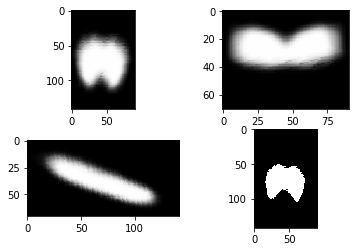

In [298]:
# prepare image and figure
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

axes[0].imshow( data_atlas[40,:,:], cmap='gray', vmin=0, vmax=1 )
axes[1].imshow( data_atlas[:,40,:], cmap='gray', vmin=0, vmax=1 )
axes[2].imshow( data_atlas[:,:,40], cmap='gray', vmin=0, vmax=1 )
axes[3].imshow( data_atlas[40]>.95, cmap='gray', vmin=0, vmax=1 )


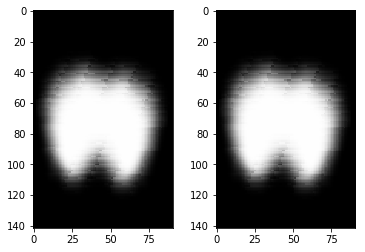

In [302]:
fig, axes = plt.subplots(1,2)

axes[0].imshow( data_atlas[40,:,:], cmap='gray', vmin=0, vmax=1 )
axes[1].imshow( data_ucsd1[40,:,:], cmap='gray', vmin=0, vmax=1 )

In [296]:
DATA_ROOTDIR = '/media/alexn/BstemAtlasDataBackup/ucsd_brain/'

fn_ucsd1 = DATA_ROOTDIR+'probability_volumes/UCSD001/UCSD001_detector799_10.0um_scoreVolume_warp0_UCSD001_\
detector799_10.0um_scoreVolume_10.0um/score_volumes/UCSD001_detector799_10.0um_scoreVolume_warp0\
_UCSD001_detector799_10.0um_scoreVolume_10.0um_12N'

blosc_to_npz(fn_atlas)
data_atlas = get_npz_data(fn_atlas)

blosc_to_npz(fn_ucsd1)
data_ucsd1 = get_npz_data(fn_ucsd1)

Size of bloscpack data:
(71, 142, 91)

Size of bloscpack data:
(71, 142, 91)



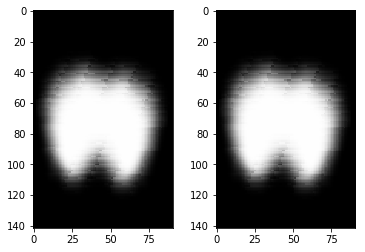

In [302]:
fig, axes = plt.subplots(1,2)

axes[0].imshow( data_atlas[40,:,:], cmap='gray', vmin=0, vmax=1 )
axes[1].imshow( data_ucsd1[40,:,:], cmap='gray', vmin=0, vmax=1 )

# Surround Score volume viz

In [88]:
fn = '12N_scorevolumes/atlasV7_10.0um_scoreVolume_12N_surround_200um'
blosc_to_npz(fn)
data = get_npz_data(fn)

Size of bloscpack data:
(128, 174, 136)



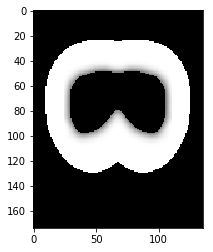

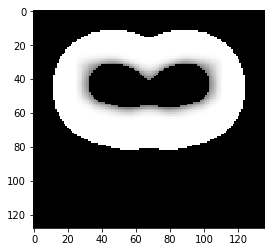

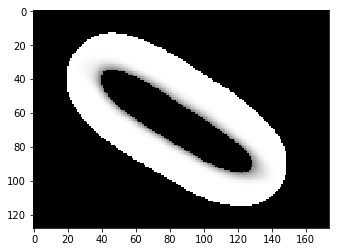

In [99]:
# Plotted on X, Y, Z planes
plt.imshow(data[55,:,:], cmap='gray', vmin=0, vmax=1)
plt.show()

plt.imshow(data[:,50,:], cmap='gray', vmin=0, vmax=1)
plt.show()

plt.imshow(data[:,:,60], cmap='gray', vmin=0, vmax=1)
plt.show()

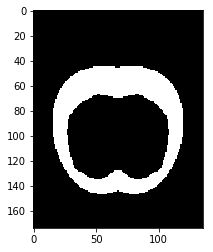

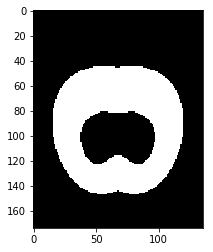

In [103]:
# Over a certain threshold
plt.imshow(data[77,:,:]>0.999, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(data[77,:,:]>0.5, cmap='gray', vmin=0, vmax=1)
plt.show()